# Test 8

Evolve GS obtained from Simulated Annealing


In [1]:
import os
import sys

import numpy as np
import pandas as pd
import random
from math import isclose

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # Ignore some messages from pandas

from tqdm import tqdm
import matplotlib.pyplot as plt

sys.path.insert(0, '../icenumerics/')
import icenumerics as ice
from auxiliary import *
from montecarlo_tools import *

ureg = ice.ureg

%reload_ext autoreload
%autoreload 2

idx = pd.IndexSlice

/home/leogabac/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Running the simulations

In [2]:
def getSimulation():
    sp = ice.spins()

    # Initialize some parameters
    trapSep = 10*ureg.um
    particleRadius = 5*ureg.um
    totalTime = 60*ureg.s
    framespersec = 20*ureg.Hz;
    dt = 10*ureg.ms

    L = 30*ureg.um
    N = 10

    # Create simulation objects
    sp.create_lattice("square",[N,N],lattice_constant=L, border="periodic")

    particle = ice.particle(radius = particleRadius,
                susceptibility = 0.0576,
                diffusion = 0.125*ureg.um**2/ureg.s,
                temperature = 300*ureg.K,
                density = 1000*ureg.kg/ureg.m**3)

    trap = ice.trap(trap_sep = trapSep,
                height = 4*ureg.pN*ureg.nm,
                stiffness = 1e-3*ureg.pN/ureg.nm)
    

    # Load the GS and prepare the colloidal ice object from that
    gs_ctrj = pd.read_csv("../data/gs90deg.csv",index_col=0)

    col = get_colloids_from_ctrj(gs_ctrj,particle,trap)

    col.region = np.array([[0,0,-3*(particleRadius/L/N).magnitude],[1,1,3*(particleRadius/L/N).magnitude]])*N*L

    world = ice.world(
        field = 8*ureg.mT,
        temperature = 300*ureg.K,
        dipole_cutoff = 200*ureg.um)


    col.simulation(world,
                name = "test",
                include_timestamp = False,
                targetdir = r".",
                framerate = framespersec,
                timestep = dt,
                run_time = totalTime,
                output = ["x","y","z","mux","muy","muz"])

    # Field
    col.sim.field.fieldx = "v_Bmag"
    col.sim.field.fieldy = "0"
    col.sim.field.fieldz = "0"

    col.run_simulation();

    col.load_simulation()

    return col

## Little sanity check before continuing

In [ ]:
col = getSimulation()
col.trj.to_csv('../data/test8/trj/trj.csv')
trj = ice.get_ice_trj(col.trj, bounds = col.bnd)
trj.to_csv('../data/test8/ctrj/ctrj.csv')

In [ ]:
trj_raw = trj = pd.read_csv("../data/test8/trj/trj.csv", index_col=[0,1])
ctrj_raw = pd.read_csv("../data/test8/ctrj/ctrj.csv", index_col=[0,1])

fig, ax = plt.subplots(1,3,figsize=(9,2),dpi=150)

ax[0].plot(np.array(trj_raw.loc[idx[:,1],"t"]),np.array(trj_raw.loc[idx[:,1],"mux"]))
ax[1].plot(np.array(trj_raw.loc[idx[:,1],"t"]),np.array(trj_raw.loc[idx[:,1],"muy"]))
ax[2].plot(np.array(trj_raw.loc[idx[:,1],"t"]),np.array(trj_raw.loc[idx[:,1],"muz"]))

In [ ]:
trj = trj_raw.loc[0,:]
ctrj = ctrj_raw.loc[0,:]

v = ice.vertices()
v = v.trj_to_vertices(ctrj)
v.vertices

In [ ]:
fig,ax = plotColloid(trj_raw,0)
v.display(ax)

## Actual simulations

In [ ]:
runs = 10

for i in range(1,runs+1):
    print(f"===== Experiment number {i} =====")
    col = getSimulation()

    filename = f"trj{i}.csv"
    print(filename)
    col.trj.to_csv('../data/test8/trj/' + filename)
    print('Saved trj')
    
    filename = f"ctrj{i}.csv"
    print(filename)
    trj = ice.get_ice_trj(col.trj, bounds = col.bnd)
    trj.to_csv('../data/test8/ctrj/' + filename)
    print('Saved centered trj')

# Getting vertices

In [ ]:
trjPath = "../data/test8/trj/"
ctrjPath = "../data/test8/ctrj/"
verticesPath = "../data/test8/vertices/"

# Get the number of realizations
_, _, files = next(os.walk(trjPath))
realizations = len(files)

for i in range(1,realizations):
    print("============================================================")
    print(f"Working on realization {i}")

    # Importing files
    trjFile = trjPath + f"trj{i}.csv"
    print(f"Opening " + trjFile)
    ctrjFile = ctrjPath + f"ctrj{i}.csv"
    print(f"Opening " + ctrjFile)
    trj_raw = trj = pd.read_csv(trjFile, index_col=[0,1])
    ctrj_raw = pd.read_csv(ctrjFile, index_col=[0,1])

    v = ice.vertices()
    frames = ctrj_raw.index.get_level_values("frame").unique()

    verticesFile = verticesPath + f"vertices{i}.csv"
    v.trj_to_vertices(ctrj_raw.loc[frames[::25]])

    print(f"Saving vertices to " + verticesFile)
    v.vertices.to_csv(verticesFile)

# Analysis

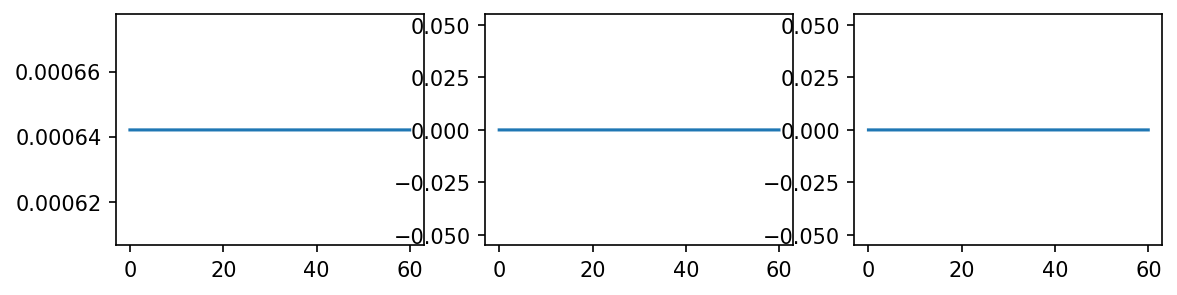

In [3]:
trj_raw = trj = pd.read_csv("../data/test8/trj/trj1.csv", index_col=[0,1])
ctrj_raw = pd.read_csv("../data/test8/ctrj/ctrj1.csv", index_col=[0,1])

fig, ax = plt.subplots(1,3,figsize=(9,2),dpi=150)

ax[0].plot(np.array(trj_raw.loc[idx[:,1],"t"]),np.array(trj_raw.loc[idx[:,1],"mux"]))
ax[1].plot(np.array(trj_raw.loc[idx[:,1],"t"]),np.array(trj_raw.loc[idx[:,1],"muy"]))
ax[2].plot(np.array(trj_raw.loc[idx[:,1],"t"]),np.array(trj_raw.loc[idx[:,1],"muz"]))

In [4]:
# Import and classify the vertices
verticesFolderPath = "../data/test8/vertices/"
vertices = getVerticesDict(verticesFolderPath)

In [5]:
counts = getVerticesCount(vertices)

number  fraction
frame type                  
0     I         41  0.506173
      VI        40  0.493827
      II         0  0.000000
      IV         0  0.000000
25    I         41  0.506173
...            ...       ...
1150  IV         1  0.012346
1175  I         36  0.444444
      VI        40  0.493827
      II         4  0.049383
      IV         1  0.012346

[192 rows x 2 columns]

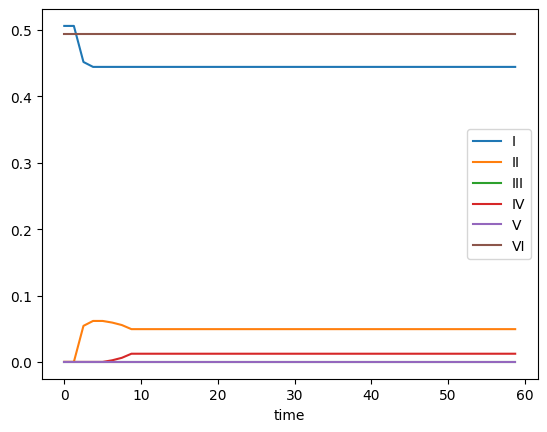

In [6]:
timeSeries = getVerticesAverage(counts,20)
ax = plt.gca()
types = timeSeries.columns.to_list()[1:]
for col in types:
    timeSeries.plot(kind='line',
        x='time',
        y=col,
        ax=ax
        )


In [27]:
# getting the last ctrj

lastFrame = trj_raw.index.get_level_values("frame")[-1]

trapSep = 10*ureg.um
particleRadius = 5*ureg.um
totalTime = 180*ureg.s

L = 30*ureg.um
N = 10

particle = ice.particle(radius = particleRadius,
            susceptibility = 0.0576,
            diffusion = 0.125*ureg.um**2/ureg.s,
            temperature = 300*ureg.K,
            density = 1000*ureg.kg/ureg.m**3)

trap = ice.trap(trap_sep = trapSep,
            height = 4*ureg.pN*ureg.nm,
            stiffness = 1e-3*ureg.pN/ureg.nm)

last_ctrj = ctrj_raw.loc[lastFrame,:].drop("type",axis="columns")
col = get_colloids_from_ctrj(last_ctrj,particle,trap)
col.region = np.array([[0,0,-3*(particleRadius/L/N).magnitude],[1,1,3*(particleRadius/L/N).magnitude]])*N*L

In [ ]:
fig, ax = plt.subplots(figsize = (5,5))

v = ice.vertices()
v = v.colloids_to_vertices(col)
col.display(ax)
v.display(ax)

In [ ]:
getPaintedFrame(trj_raw,ctrj_raw,0,20)

In [ ]:
getPaintedFrame(trj_raw,ctrj_raw,lastFrame,20)

# Computing energy as a function of time

In [7]:
B0 = 8*ureg.mT
field = [1,0,0]*B0
field

Magnitude,[8 0 0]
Units,millitesla


In [ ]:
energies = np.zeros(len(frames))
for frame in tqdm(frames.to_list()):
    current_ctrj = ctrj_raw.loc[frame,:].drop(["type", "t"],axis=1)
    current_col = get_colloids_from_ctrj(current_ctrj,particle,trap)
    current_col.region = np.array([[0,0,-3*(particleRadius/L/N).magnitude],[1,1,3*(particleRadius/L/N).magnitude]])*N*L
    current_energy = current_col.calculate_energy(B = field).magnitude
    energies[frame] = current_energy


In [ ]:
fig , ax = plt.subplots(figsize=(5,5))
ax.plot(np.array(frames)/20,energies)
ax.set_xlabel("Frames")

In [54]:
initial_col = get_colloids_from_ctrj(ctrj_raw.loc[0,:].drop(["type", "t"],axis=1),particle,trap)
initial_col.region = np.array([[0,0,-3*(particleRadius/L/N).magnitude],[1,1,3*(particleRadius/L/N).magnitude]])*N*L
initial_energy = initial_col.calculate_energy(B = field)


In [55]:
final_col = get_colloids_from_ctrj(ctrj_raw.loc[lastFrame,:].drop(["type", "t"],axis=1),particle,trap)
final_col.region = np.array([[0,0,-3*(particleRadius/L/N).magnitude],[1,1,3*(particleRadius/L/N).magnitude]])*N*L
final_energy = final_col.calculate_energy(B = field)

In [ ]:
final_energy - initial_energy

In [18]:
energies = pd.read_csv("../data/test8/energies.csv",index_col=0)["0"].to_numpy()
frames = trj_raw.index.get_level_values("frame").unique().to_numpy()

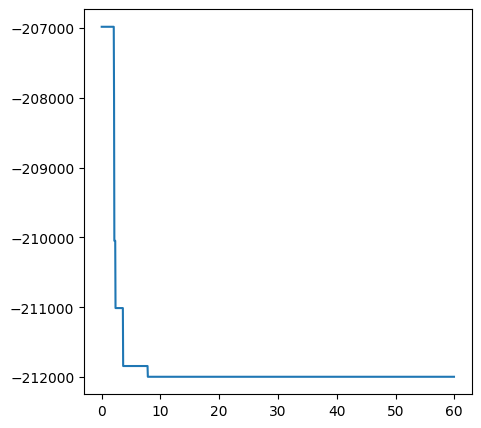

In [19]:
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(frames/20,energies)
plt.show()